In [1]:
# Jouer un fichier .wav
import utils

for song in utils.getSongs():
    play_obj = song.play()
    play_obj.wait_done()

## Outils nécessaire

- Python
- Jupyter Notebook: REPL qui permet d'exécuter du code (principalement Python) dans un navigateur. Permet de créer un document (un notebook) divisé en plusieurs cellules (du code ou du texte)
- Numpy: Librairie dédiée au calcul scientifique (structures de données, opérations sur ces structures, optimisation)
- Matplotlib: Librairie dédiée à la visualisation de données (graphiques statiques, dynamiques et intéractifs)
- Simplaudio: Librairie qui fournit de quoi jouer des sons sur n'importe quelle plateforme

## Créer un son

Un son numérique se traduit par:
- une durée
- un ensemble de valeurs définies sur cette durée
- une fréquence d'acquisition (= échantillonnage), le nb de valeurs enregistrées par seconde, 44.1 kHz le plus souvent (dû à https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)

Toutes notes possèdent une fréquence fondamentale = sa hauteur. Correspond au nombre de vibrations par seconde.
Quand on joue une note avec un instrument, on joue la fréquence fondamentale, et des multiples de cette fréquence (les harmoniques).
L'ensemble des fréquences + amplitudessonore de chacune = le timbre, qui est unique entre chaque instrument.

Si on multiple la fréquence d'une note par un multiple de 2, alors c'est la même note mais à l'octave supérieure (c'est la même note mais plus aigue). LA 3 = 440Hz, LA 4 = 880Hz.

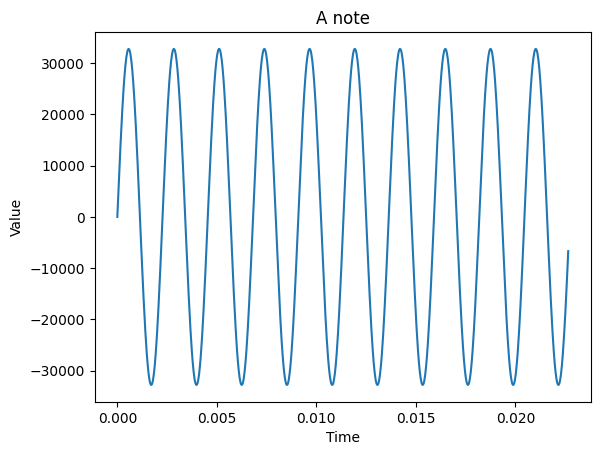

In [39]:
# Play A key
import matplotlib.pyplot as plt
import numpy as np
import math

samplePerSecond = 44100 
duration = 0.25

# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0, *, device=None)
t = np.linspace(0, duration, math.floor(duration * samplePerSecond), False)

A = np.sin(440 * t * 2 * np.pi)

# Normalization to ensure that highest value is in 16-bit range
audioA = A * (2**15 - 1) / np.max(np.abs(A))
audioA = audioA.astype(np.int16)

plt.plot(t[0:1000], audioA[0:1000], label="A")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('A note')
 
plt.show()

In [ ]:
# Play differents A notes

import numpy as np
import simpleaudio as sa
import math
import time

frequency = 110
samplePerSecond = 44100 
duration = 0.25

# Generate array with seconds*sample_rate steps, ranging between 0 and duration
t = np.linspace(0, duration, math.floor(duration * samplePerSecond), False)

# Generate multiple LA
la = [np.sin(frequency * t * 2 * np.pi),
      np.sin(frequency * 2 * t * 2 * np.pi),
      np.sin(frequency * 4 * t * 2 * np.pi),
      np.sin(frequency * 8 * t * 2 * np.pi)]

for note in la:
    time.sleep(1)
    # Normalization to ensure that highest value is in 16bit range
    audio = note * (2**15 - 1) / np.max(np.abs(note))
    # Convert to 16-bit data
    audio = audio.astype(np.int16)
    # Start playback
    play_obj = sa.play_buffer(audio, 1, 2, samplePerSecond)
    # Wait for playback to finish before exiting
    play_obj.wait_done()

## Accord

Un accord c'est juste un ensemble de notes jouées ensemble

In [83]:
import numpy as np
import simpleaudio as sa
import math

# Get timesteps for each sample, T is the note duration in seconds
sample_rate = 44100
T = 4
t = np.linspace(0, T, math.floor(T * sample_rate), False)

# Generate sine wave notes
A_note = np.sin(440 * t * 2 * np.pi)
C_note = np.sin(261.63 * t * 2 * np.pi)
G_note = np.sin(392.00 * t * 2 * np.pi)
D_note = np.sin(293.66 * t * 2 * np.pi)
F_note = np.sin(349.23 * t * 2 * np.pi)

# Mix audio together
audio = np.zeros((44100*T))
n = len(t)
audio += A_note
audio += C_note
audio += G_note
audio += D_note

# audio[0+x:n+x] += 0.5 * note to blend a note in a subpart of the song 

# Normalize to 16-bit range
audio *= 32767 / np.max(np.abs(audio))
# Convert to 16-bit data
audio = audio.astype(np.int16)

# Start playback
play_obj = sa.play_buffer(audio, 2, 2, sample_rate)

# Wait for playback to finish before exiting
play_obj.wait_done()


## Analyse des sons d'oiseaux

On va d'abord afficher la représentation temporelle (l'évolution de l'amplitude du son en fonction du temps) d'un son d'oiseau.

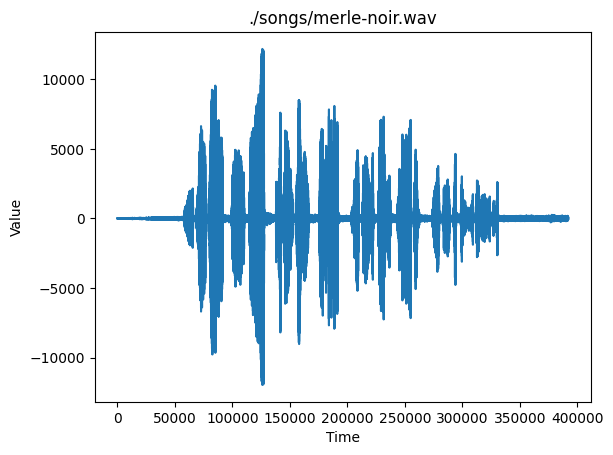

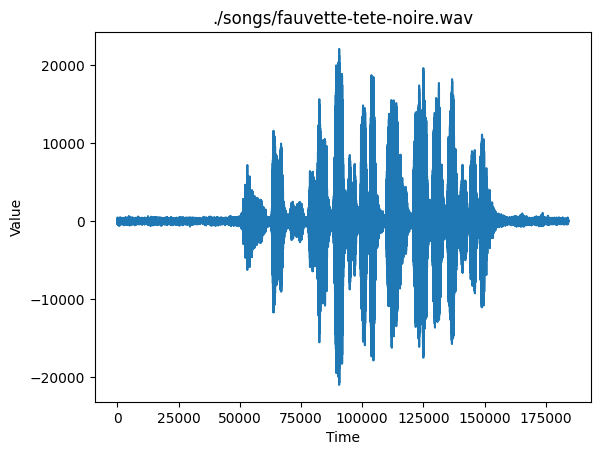

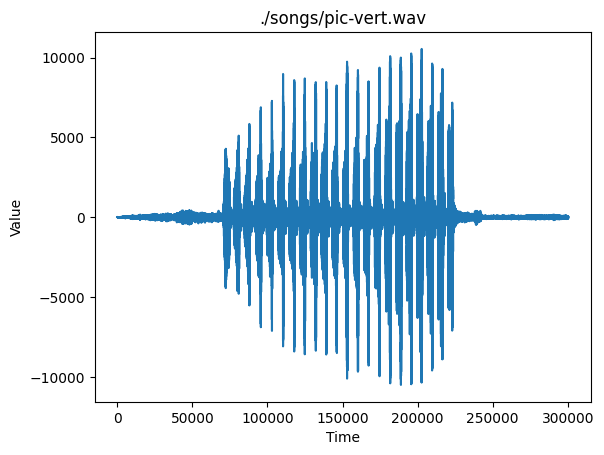

In [2]:
import simpleaudio as sa
import numpy as np
import matplotlib.pyplot as plt
import utils

def draw(audio, filepath):
    plt.figure(filepath)
    plt.plot(range(0, len(audio)), audio)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(filepath)

def playAudio(audio, wave_file):
    play_obj = sa.play_buffer(audio, wave_file.num_channels, wave_file.bytes_per_sample, wave_file.sample_rate)
    play_obj.wait_done()

for song in utils.getSongs():
    audio = np.frombuffer(song.audio_data, 'int16')
    draw(audio, song.filepath)

# Transformer un son

Un son pur est une vibration sinusoïdale de l'air à une certaine fréquence et avec une certaine amplitude (les notes évoquées plus haut, exemple "La"). Tous les sons plus complexes, comme par exemple, le chant d'un oiseau, peuvent se décomposer en une somme de sons purs. Cette décomposition en fréquence donne une description plus précise du son: c'est son spectre.

L'outil mathématique permettant de passer du domaine temporel au domaine fréquentiel (et inversement) est la transformée de Fourier. Qui permet de manipuler beaucoup plus facilement un son: amplifier les aigus, graves, supprimer le bruit dans le domaine fréquentiel, pour ensuite le repasser dans le domaine temporel pour obtenir un son modifié.

L'enregistrement d'un son d'oiseau étant "discret" (il est échantilloné et n'est donc pas continu), on utilise pour cela une variante dédiée de la transformée de Fourier, la "Transformée de Fourier discrète", dont une implémentation est fournie par Numpy: https://numpy.org/doc/stable/reference/routines.fft.html.

In [ ]:
# Filter high values in time domain, based on the amplitude
import simpleaudio as sa
import numpy as np
import matplotlib.pyplot as plt

wave_obj = sa.WaveObject.from_wave_file('./songs/merle-noir.wav')

audio = np.frombuffer(wave_obj.audio_data, 'int16')

filteredAudio = np.where(audio > 0,0, audio)

play_obj = sa.play_buffer(filteredAudio, wave_obj.num_channels, wave_obj.bytes_per_sample, wave_obj.sample_rate)
play_obj.wait_done()

plt.plot(range(0, len(filteredAudio)), filteredAudio)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Merlou')

Résultat de la transformée de Fourier: https://www.checkhearing.org/audioPlotSpectrum.php 

Merle
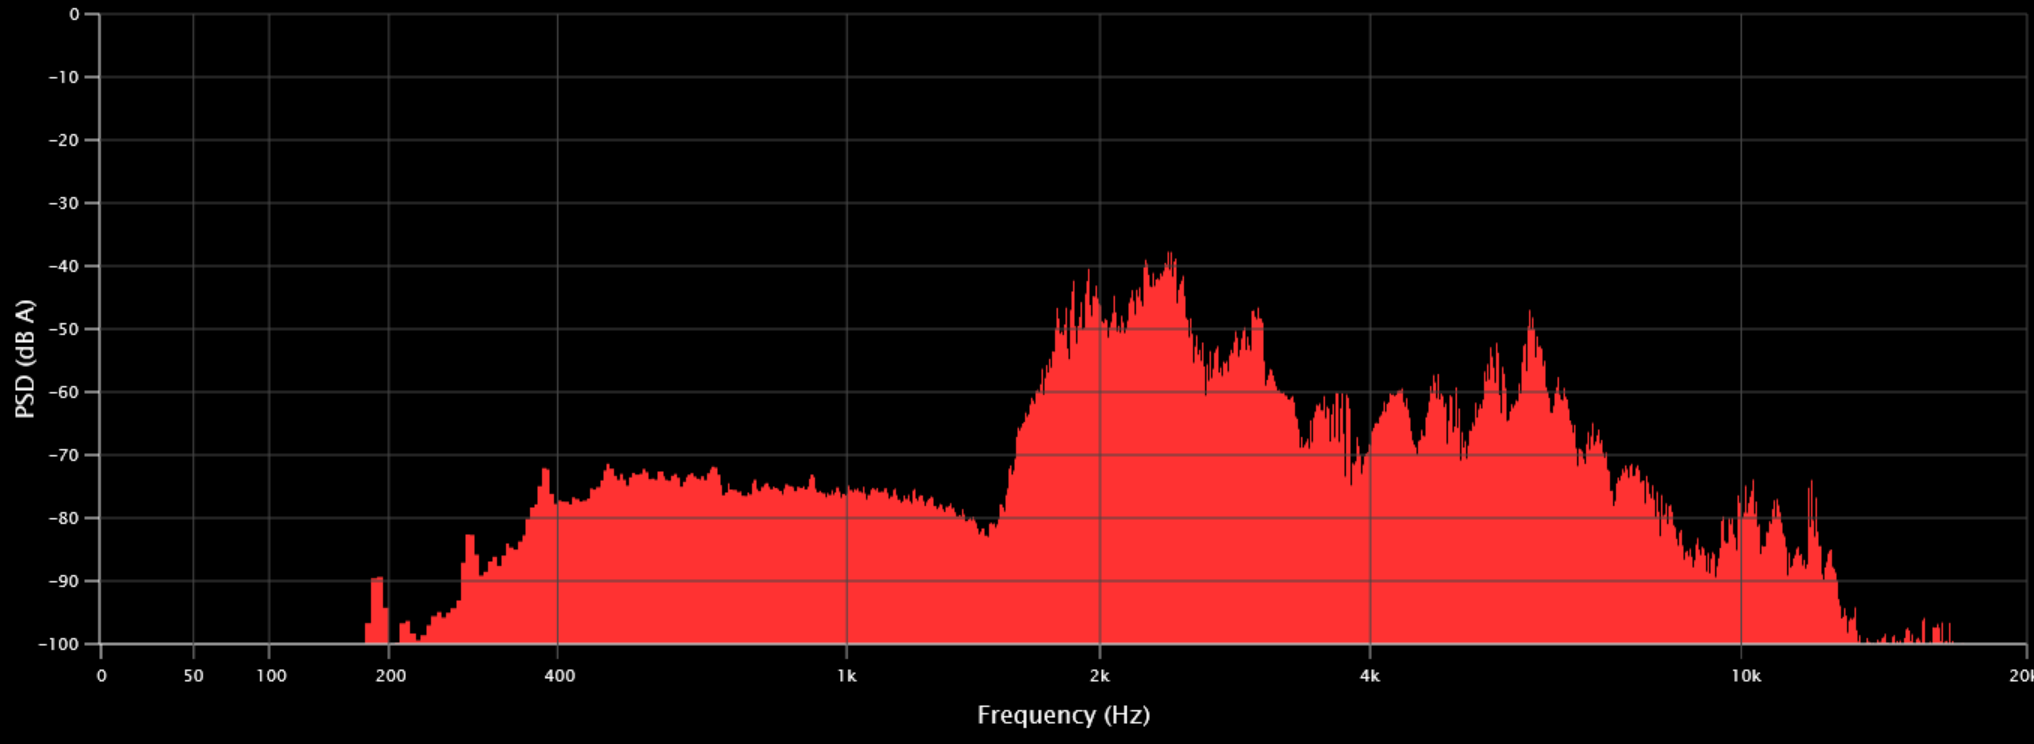

Fauvette
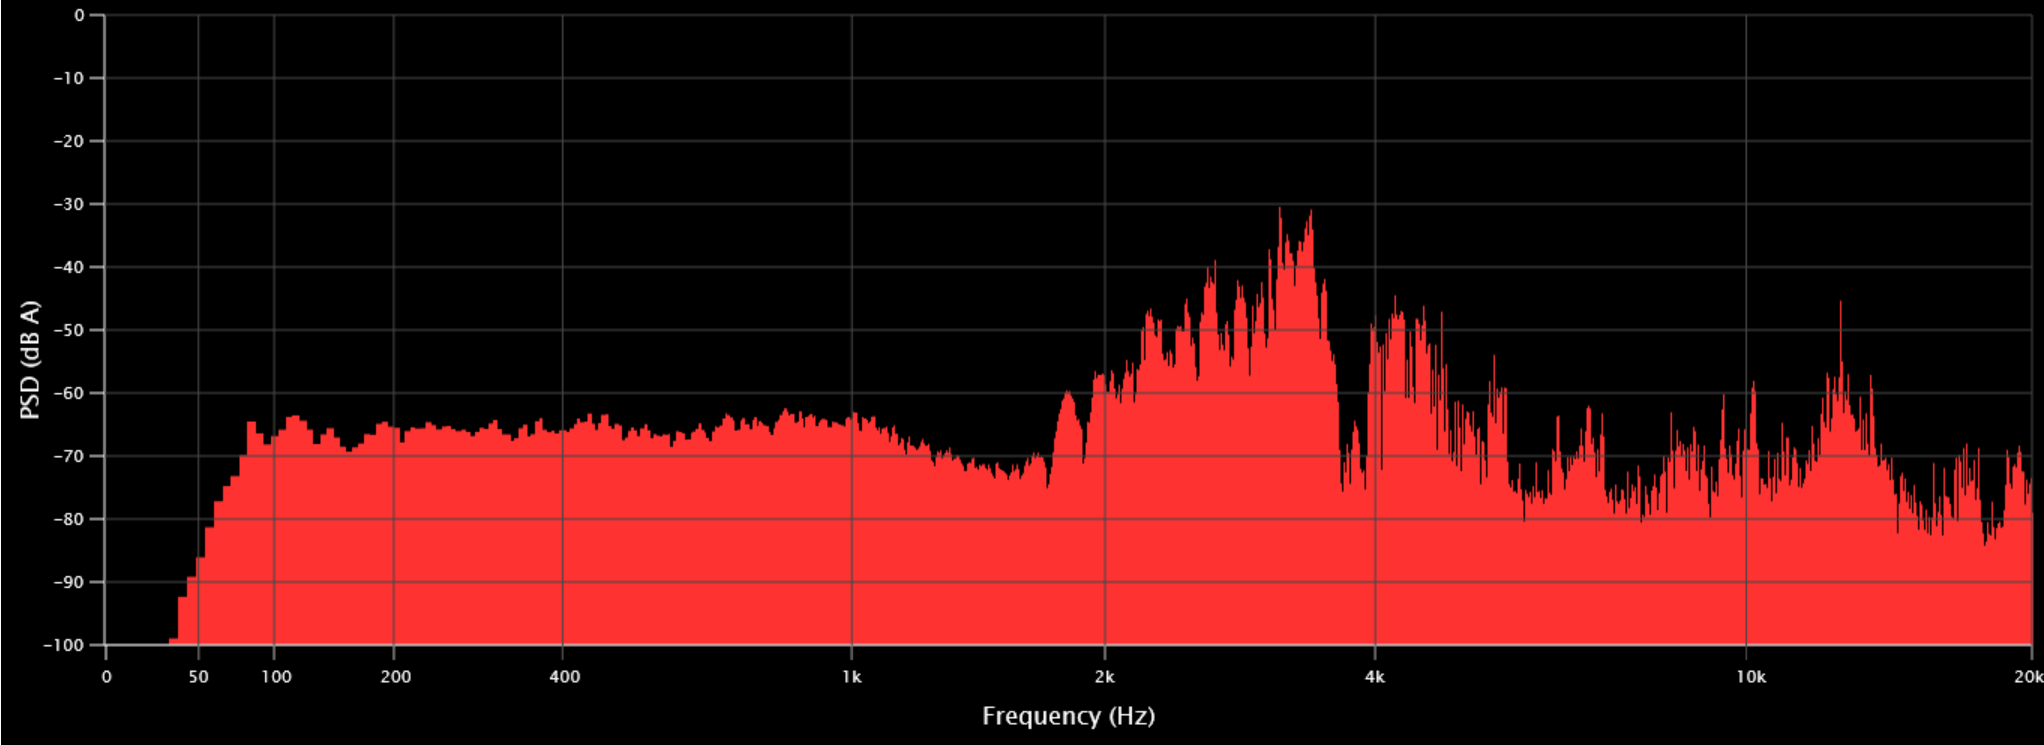

Pic vert
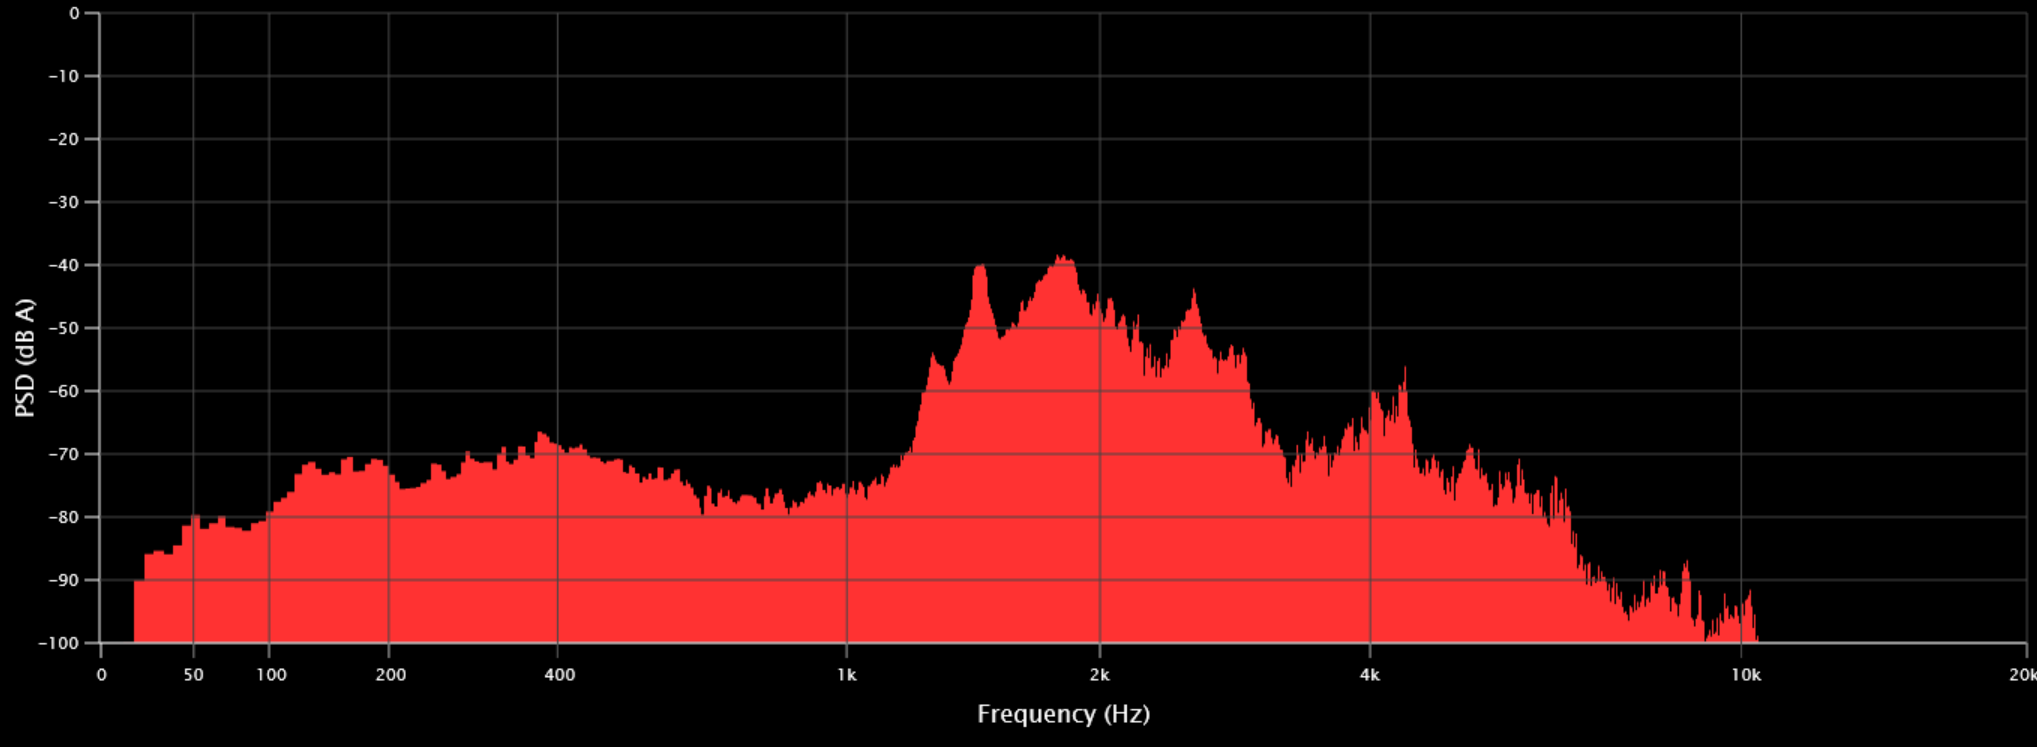

In [ ]:
# Try to plot a bird song FT result
import simpleaudio as sa
import numpy as np
import matplotlib.pyplot as plt

# fft.fft(a, n=None, axis=-1, norm=None, out=None)

wave_obj = sa.WaveObject.from_wave_file('./songs/merle-noir.wav')

audio = np.frombuffer(wave_obj.audio_data, 'int16')

Y = np.fft.fft(audio)
freq = np.fft.fftfreq(len(audio), t[1] - t[0])

plt.figure()
plt.plot( freq, np.abs(Y) )
plt.figure()

# Analyses via spectrogramme
Les ornithologues utilisent un spectrogramme (= sonogramme) pour représenter les principales caractéristiques d'un chant d'oiseau:
- temps (axe horizontal)
- fréquence (axe vertical)
- puissance/intensité (couleur du tracé)

Il est le plus complet car il permet de visualiser l'évolution du spectre du son au cours du temps.

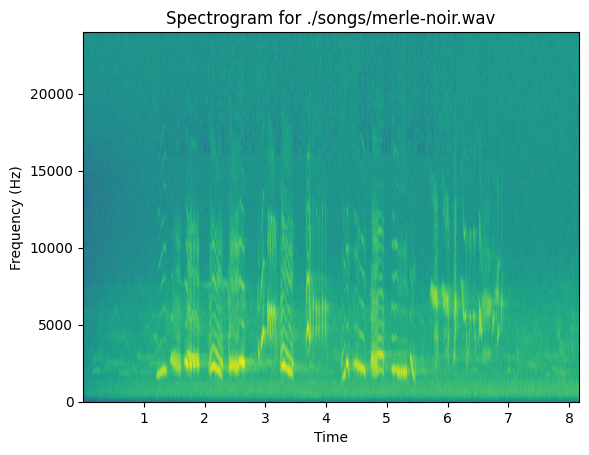

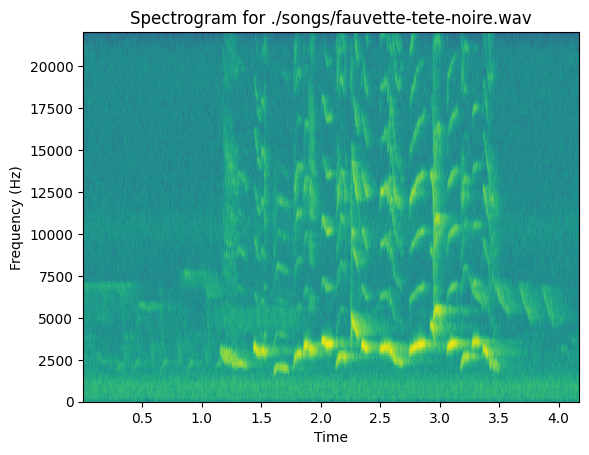

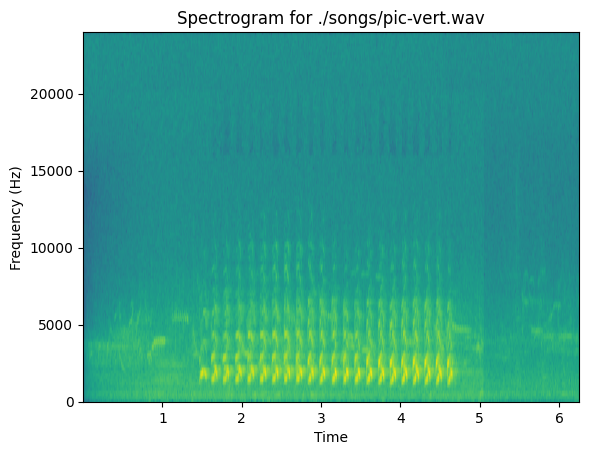

In [113]:
# Draw spectrograms of all birds songs
import simpleaudio as sa
import numpy as np
import matplotlib.pyplot as plt

for song in utils.getSongs():
    audio = np.frombuffer(song.audio_data, 'int16') 
    plt.specgram(audio, Fs=song.sample_rate,scale='dB') # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram for '+song.filepath)
    plt.show()

# échelle en dB: si P1 = 2 × P0, leur rapport est de 2 ≈ 100,3, ce qui correspond à 3 dB. Ainsi, multiplier par 2 une puissance correspond à ajouter 3 dB.

# Identifier des oiseaux par le son

En étudiant dans le domaine fréquentiel l'enregistrement du chant d'un oiseau, on peut obtenir la liste des fréquences émises par cet oiseau. Cette ensemble de fréquences sont caractéristiques de cet oiseau et définit donc une "emprunte" unique.
On doit donc pouvoir ensuite comparer avec d'autres enregistrements pour émettre des hypothèses d'identifications.

Il y a un peu moins de 500 espèces d'oiseaux en France, les enregistrements sont disponibles dans des services comme: https://xeno-canto.org/.

Il existe deux grandes catégories de sons d'oiseaux, la première c'est la plus connue: le chant, avec des des vocalisations longues constituées de notes très variées, l'autre c'est les cris avec des répétitions de notes courtes.

Objectif: avoir un professionnel dans la poche qui sait identifier les oiseaux juste par le son, en temps réel
Comme https://birdnet.cornell.edu/api/ / birdnet sur téléphone

"If it looks like a duck, and quacks like a duck, we have at least to consider
the possibility that we have a small aquatic bird of the family anatidae
on our hands."

Difficultés envisagées:
- grosse diversité intraspécifique (sons différents selon l'âge, sexe, l'individu, l'accent géographique, plusieurs cris ou chants pratiqués par un seul oiseau)
- certains oiseaux sont des imitateurs d'autres oiseaux ou de n'importe quels sons qu'ils entendent
- altérations à l'enregistrement (propagation du son qui varie selon le milieu, plusieurs oiseaux dans l'enregistrements ou autres bruits parasites, qualité du matériel)

Pour se simplifier la vie, on peut se baser sur:
- un sous-ensemble restreint d'oiseaux, avec des sonorités bien différenciées
- assigner un seul type de chant ou cri à chaque oiseau un type de son pour chaque oiseau
- des séquences en .wav, d'une durée courte et qui contient uniquement le son de l'oiseau et le moins de bruits parasites possibles

Exemple de diversité intraspécifique avec des "dialectes" de 3 groupes différents de bruant à couronne blanche (source:https://planet-vie.ens.fr/thematiques/ecologie/ethologie/comment-et-pourquoi-les-oiseaux-chantent-ils) 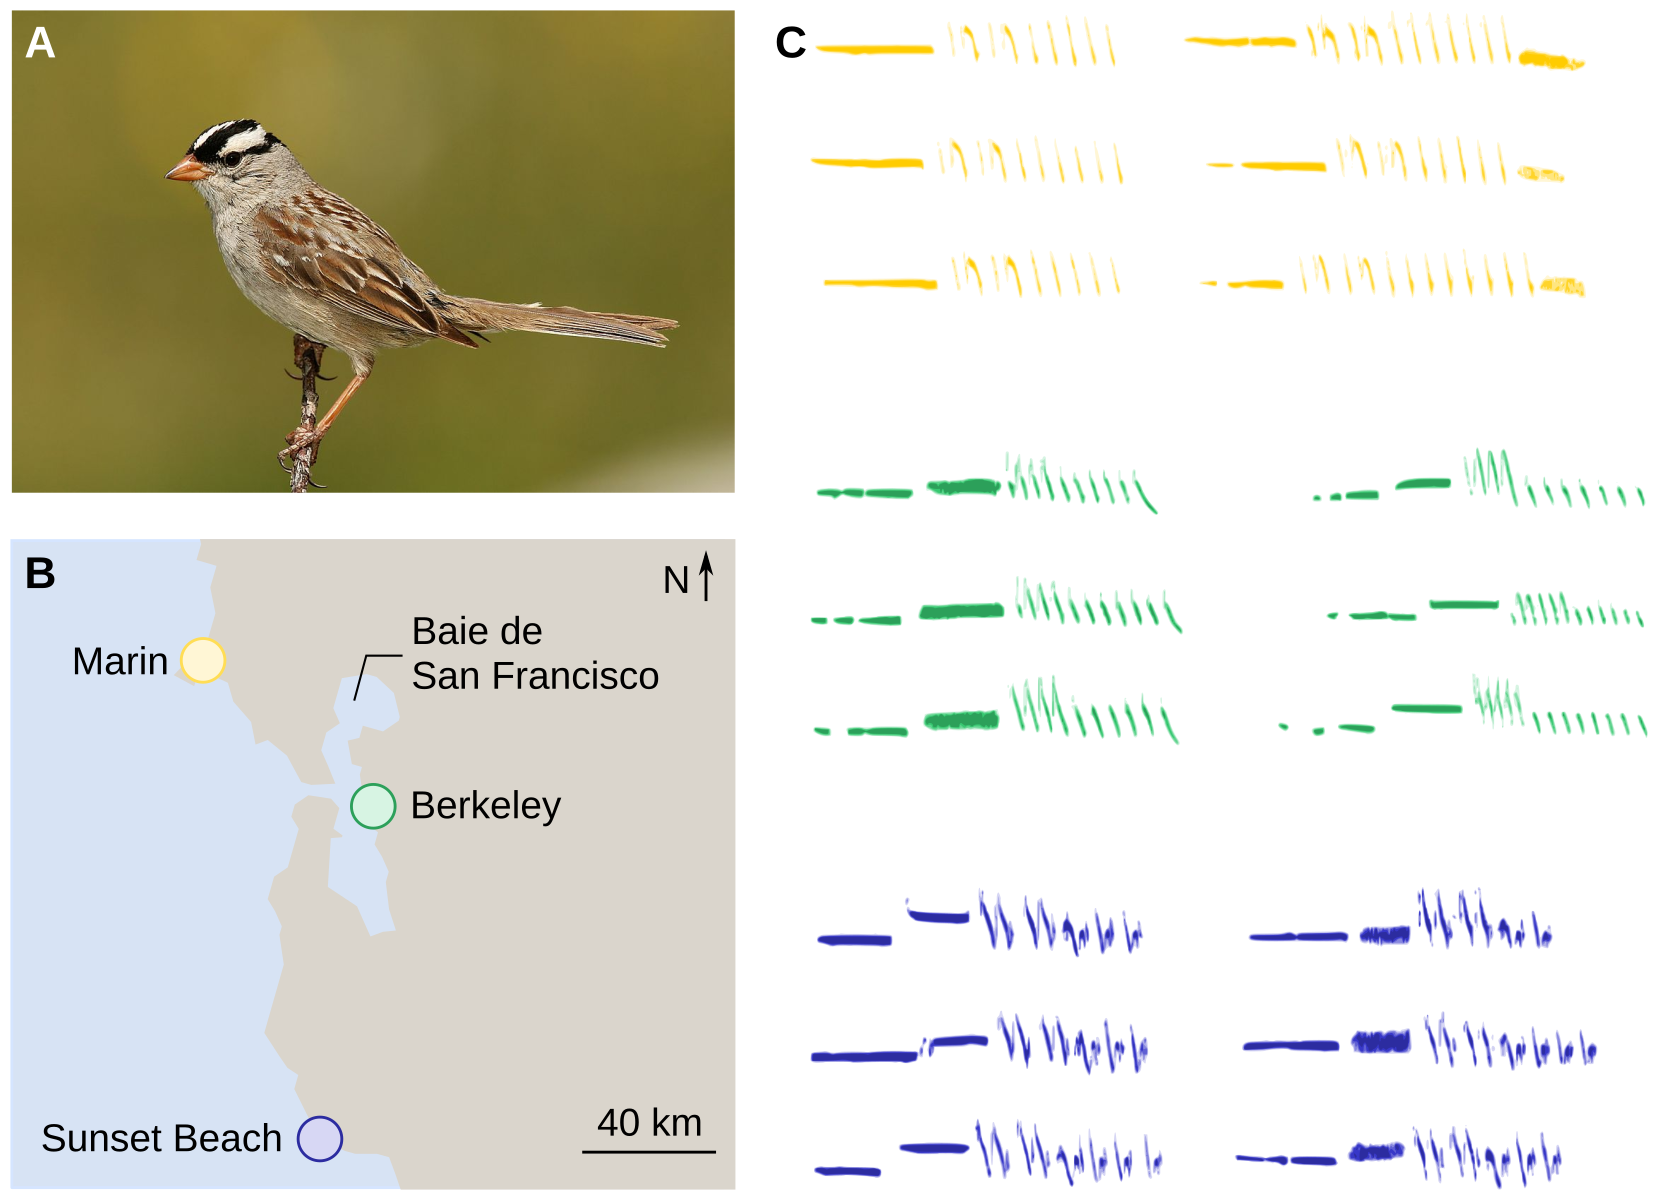

## Existing solutions to identify songs
### Machine learning
#### Mel frequency cepstral coefficients (MFCCs)
MFCCs of an audio signal are a small set of features (usually about 10–20) which describe the overall shape of the spectral envelope. MFCCs were frequently used for voice recognition (see for instance [Muda et al., 2010]) before the task started to be performed using deep learning (see for instance [Yu and Deng, 2016]).

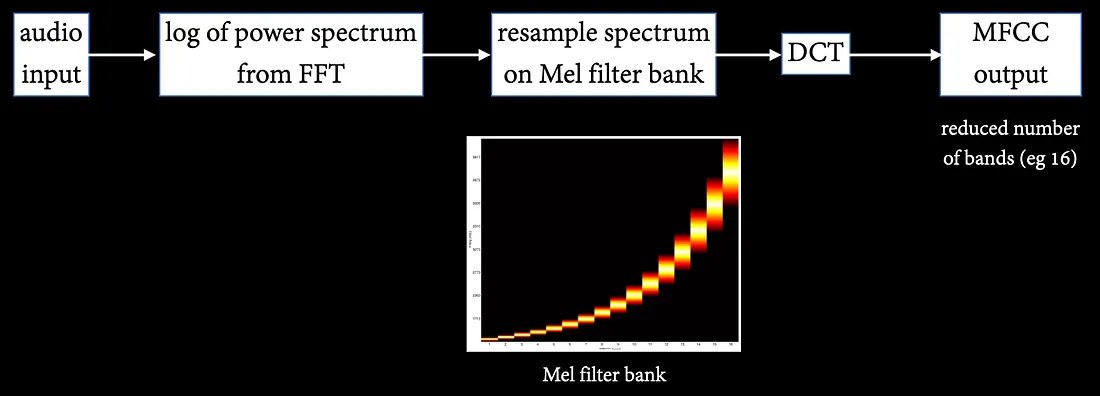

### Deep learning
#### Deep Convolutional Neural Network
https://github.com/kahst/BirdNET-Lite
https://github.com/kahst/BirdNET-Analyzer (possibilité d'entrainer le modèle sur de nouvelles espèces, y compris pas oiseaux: au moins 100 sons par espèce pour un bon résultat https://github.com/kahst/BirdNET-Analyzer?tab=readme-ov-file#8-training)